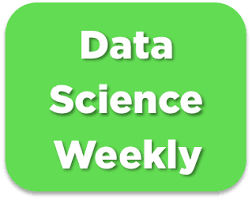

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

import warnings
warnings.filterwarnings("ignore") 

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [4]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [5]:
# Basic stats
print("Number of rows : {}".format(data_sample.shape[0]))
print()

print("Display of dataset: ")
display(data_sample.head())
print()

print("Basics statistics: ")
data_desc = data_sample.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data_sample.isnull().sum()/data_sample.shape[0])

Number of rows : 10000

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
67326,US,25,1,Seo,7,0
122991,US,31,0,Seo,3,0
145097,UK,32,0,Seo,6,0
249462,US,42,1,Direct,1,0
260945,US,29,1,Ads,2,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.000000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5645,NaN,NaN,4874,NaN,NaN
mean,NaN,30.499200,0.689400,NaN,4.845100,0.031900
std,NaN,8.282262,0.462762,NaN,3.282131,0.175743
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,6.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

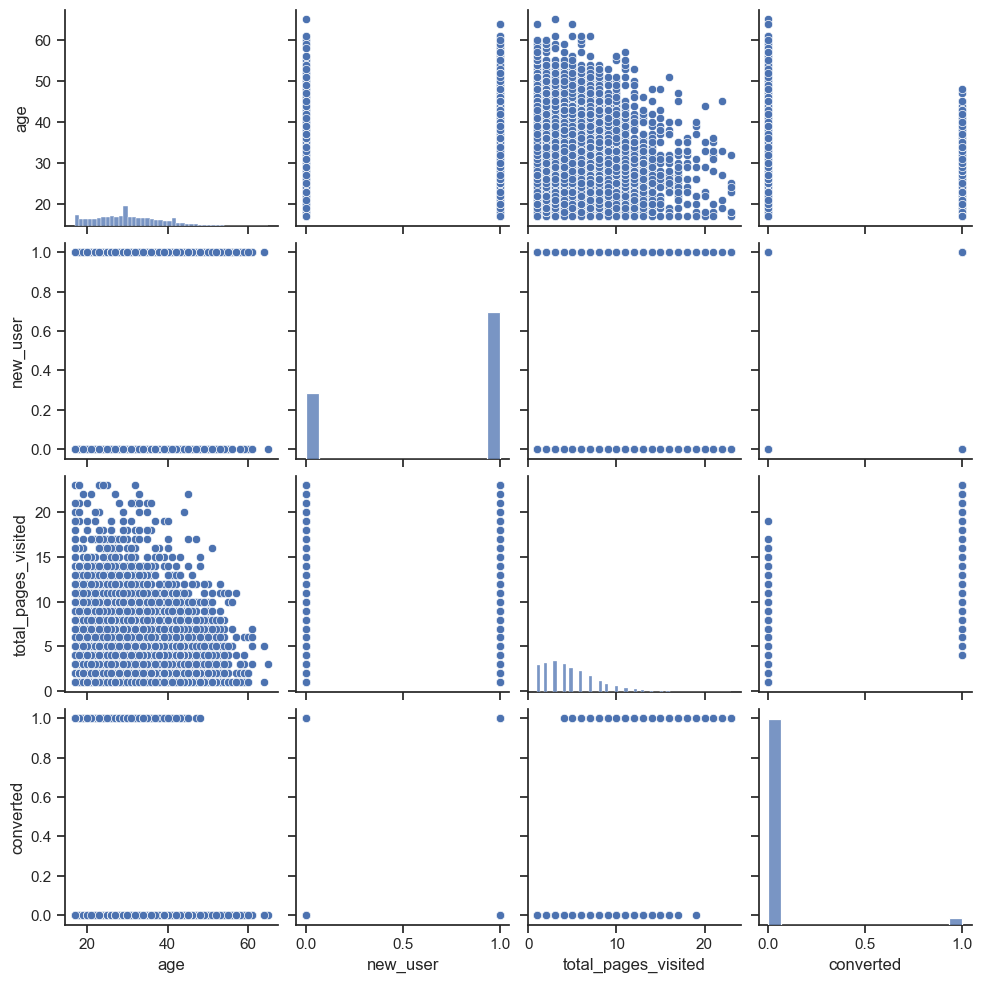

In [6]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(data_sample)

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [17]:
# Separate target variable Y from features X
target_variable = 'converted'
#features_list = ['total_pages_visited']

X = data_sample.drop(target_variable, axis = 1)
Y = data_sample.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

...Done.

Y : 
67326     0
122991    0
145097    0
249462    0
260945    0
Name: converted, dtype: int64

X :
       country  age  new_user  source  total_pages_visited
67326       US   25         1     Seo                    7
122991      US   31         0     Seo                    3
145097      UK   32         0     Seo                    6
249462      US   42         1  Direct                    1
260945      US   29         1     Ads                    2


In [18]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


In [19]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [20]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

In [21]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [22]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])


Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
76467       US   26         1     Seo                    5
156432      US   49         1  Direct                   12
22427       US   38         1     Ads                    3
158661      UK   44         1     Seo                    1
264635      UK   40         0     Seo                    6
...Done.
[[-0.5425305   0.67223926  0.04965284  0.          0.          1.
   0.          1.        ]
 [ 2.22057876  0.67223926  2.19349167  0.          0.          1.
   1.          0.        ]
 [ 0.89909173  0.67223926 -0.56287254  0.          0.          1.
   0.          0.        ]
 [ 1.61990284  0.67223926 -1.17539792  0.          1.          0.
   0.          1.        ]
 [ 1.1393621  -1.4875656   0.35591553  0.          1.          0.
   0.          1.        ]]

Encoding labels...
76467     0
156432    0
22427     0
158661    0
264635    0
Name: converted, dtype: int64
...Done
[0 0 0 0 0]

In [23]:
# Train model
svc = SVC(kernel = 'linear', probability = True) # set probability to True if you plan to use predict_proba()
svc.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [29]:
X_train.shape

(8000, 8)

In [24]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = svc.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = svc.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[9.98344253e-01 1.65574654e-03]
 [9.69557460e-01 3.04425395e-02]
 [9.99892832e-01 1.07168068e-04]
 ...
 [9.98763174e-01 1.23682621e-03]
 [9.99786698e-01 2.13302014e-04]
 [9.98279326e-01 1.72067450e-03]]



## Test pipeline

In [25]:
# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[0:5,:])
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
267490      US   48         1     Ads                    2
222727      US   58         0  Direct                    1
234361      UK   24         1     Ads                    1
280593      US   36         0     Seo                    9
50741       UK   34         0     Ads                    5
...Done.
[[ 2.10044358  0.67223926 -0.86913523  0.          0.          1.
   0.          0.        ]
 [ 3.30179543 -1.4875656  -1.17539792  0.          0.          1.
   1.          0.        ]
 [-0.78280087  0.67223926 -1.17539792  0.          1.          0.
   0.          0.        ]
 [ 0.65882136 -1.4875656   1.2747036   0.          0.          1.
   0.          1.        ]
 [ 0.41855099 -1.4875656   0.04965284  0.          1.          0.
   0.          0.        ]]

Encoding labels...
267490    0
222727    0
234361    0
280593    0
50741     0
Name: converted, dtype: int64
...Done
[0 0 0 0 0]


In [26]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = svc.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = svc.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[9.99973389e-01 2.66109047e-05]
 [9.99971656e-01 2.83438644e-05]
 [9.99859505e-01 1.40494816e-04]
 ...
 [9.99670852e-01 3.29147927e-04]
 [9.94682041e-01 5.31795928e-03]
 [9.98555858e-01 1.44414196e-03]]



## Performance assessment

In [27]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.984625
accuracy on test set :  0.9865

f1-score on training set :  0.7146171693735499
f1-score on test set :  0.7610619469026548



In [28]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[7723   22]
 [ 101  154]]

Confusion matrix on test set : 
[[1930    6]
 [  21   43]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [15]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression()

In [17]:
X.shape

(284580, 1)

In [21]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [22]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.33326238]
 [ 0.03879562]
 [-1.15919229]
 [ 0.3382926 ]
 [-0.56019834]]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [23]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**

# SVM Model

In [24]:
# Import dataset
data_svm = pd.read_csv('conversion_data_train.csv')
data_svm.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [25]:
# Basic stats
print("Number of rows : {}".format(data_svm.shape[0]))
print()

print("Display of dataset: ")
display(data_svm.head())
print()

print("Basics statistics: ")
data_desc = data_svm.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data_svm.isnull().sum()/data_svm.shape[0])

Number of rows : 284580

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

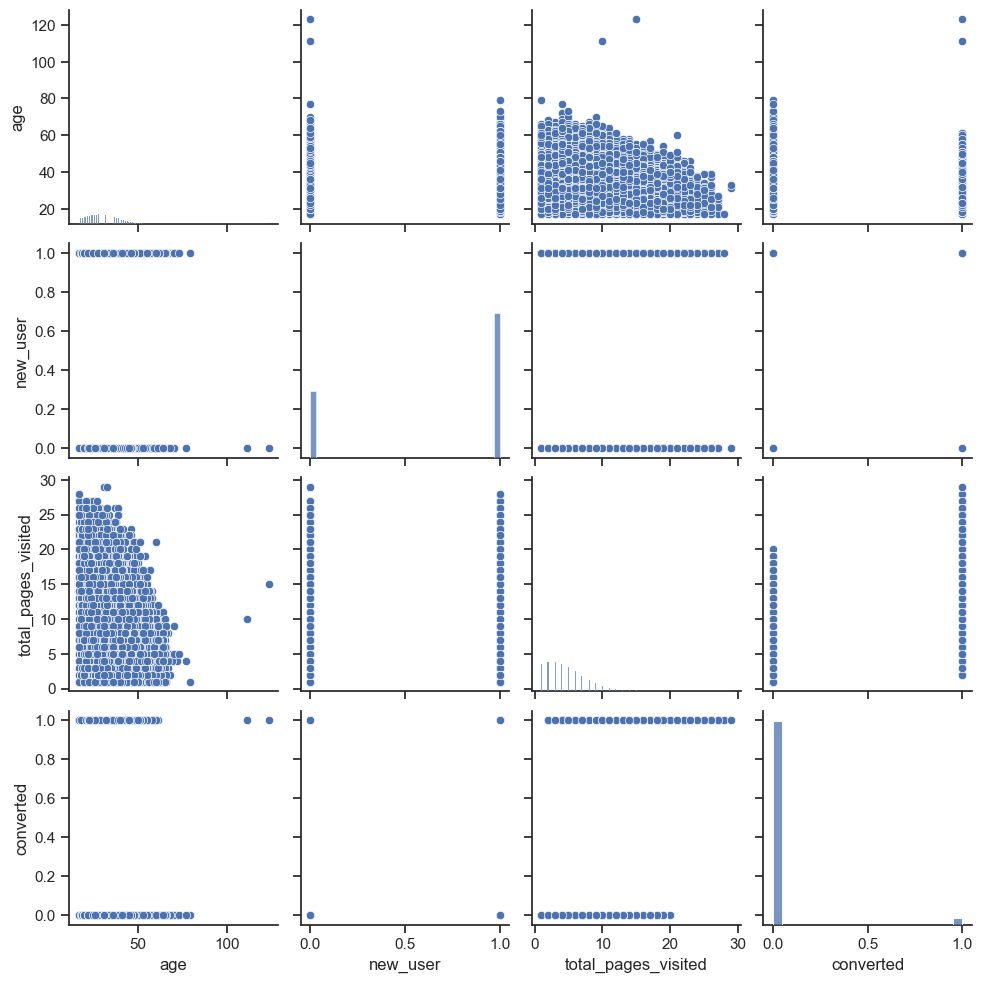

In [30]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(data_svm)

## Preprocessing

In [27]:
# Separate target variable Y from features X
target_variable = 'converted'
#features_list = ['total_pages_visited']

X = data_svm.drop(target_variable, axis = 1)
Y = data_svm.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3


In [28]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


In [31]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [35]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

In [36]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [37]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
       country  age  new_user  source  total_pages_visited
137434   China   19         1     Seo                    1
112323      US   33         1  Direct                    5
143261      US   51         1     Ads                    2
162328   China   17         0     Seo                    1
158039   China   28         1     Seo                    5
...Done.
[[-1.3990984   0.67651656 -1.15935344  0.          0.          0.
   0.          1.        ]
 [ 0.29299544  0.67651656  0.03743241  0.          0.          1.
   1.          0.        ]
 [ 2.46854467  0.67651656 -0.86015697  0.          0.          1.
   0.          0.        ]
 [-1.64082609 -1.47816042 -1.15935344  0.          0.          0.
   0.          1.        ]
 [-0.31132378  0.67651656  0.03743241  0.          0.          0.
   0.          1.        ]]

Encoding labels...
137434    0
112323    0
143261    0
162328    0
158039    0
Name: converted, dtype: int64
...Done
[0 0 0 0 0]

## Linear SVM

In [38]:
svc = SVC(kernel = 'linear', probability = True) # set probability to True if you plan to use predict_proba()
svc.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [39]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = svc.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = svc.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[9.99996319e-01 3.68094692e-06]
 [9.99579644e-01 4.20356415e-04]
 [9.99986480e-01 1.35204364e-05]
 ...
 [9.99832240e-01 1.67760147e-04]
 [8.69008179e-01 1.30991821e-01]
 [9.95842327e-01 4.15767291e-03]]



In [40]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = svc.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = svc.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[9.99966226e-01 3.37743974e-05]
 [9.95157130e-01 4.84286982e-03]
 [9.99989258e-01 1.07415764e-05]
 ...
 [9.99772330e-01 2.27669691e-04]
 [9.97372408e-01 2.62759246e-03]
 [9.99510906e-01 4.89093658e-04]]



In [42]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9862868086302622
accuracy on test set :  0.9856279429334458

f1-score on training set :  0.7624410287627456
f1-score on test set :  0.75045759609518



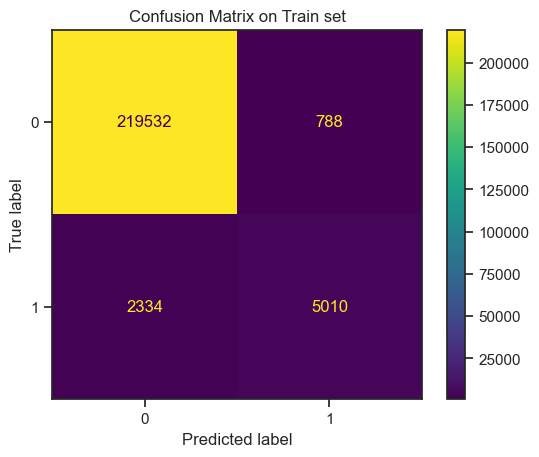

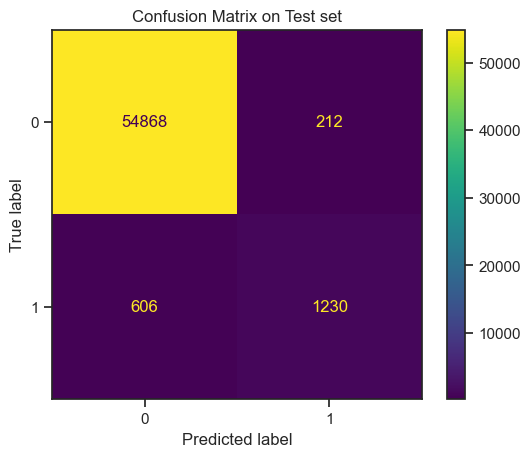

In [43]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svc, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svc, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

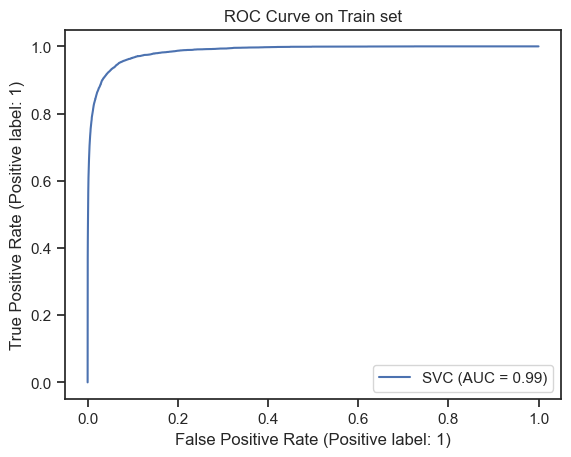

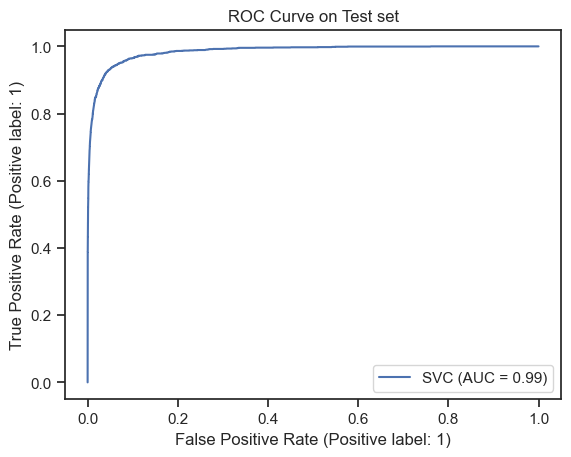

In [44]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(svc, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(svc, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

## Non-linear SVM with radial basis function

In [45]:
# Perform grid search
print("Grid search...")
classifier = SVC(kernel = 'rbf', probability = True)

# Grid of values to be tested
params = {
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.1, 1.0, 10.0]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()